## Example 2b: Nonconvex Minimax Problem with Constraints.
We consider the following possibly nonconvex-nonconcave minimax problem:
\begin{equation}
\min_{u \in \mathbb{R}^{p_1}}\max_{v\in\mathbb{R}^{p_2}}\Big\{ \mathcal{L}(u,v) = f(u) + \frac{1}{n}\sum_{i=1}^n\big[u^{\top}A_iu + u^{\top}L_iv - v^{\top}B_iv + b_i^{\top}u - c_i^{\top}v\big] - g(v) \Big\},
\end{equation}
where $A_i \in\mathbb{R}^{p_1\times p_1}$ and $B_i \in \mathbb{R}^{p_2\times p_2}$ are symmetric matrices, $b_i\in\mathbb{R}^{p_1}$, $c_i \in \mathbb{R}^{p_2}$, and $L_i \in \mathbb{R}^{p_1\times p_2}$ is a given matrix.
Here, we add two terms $f(u)$ and $g(v)$ to possibly handle constraints or regularizers associated with $u$ and $v$, respectively.

In this experiment, we consider the case where $f(u) = \delta_{\Delta_{p_1}}(u)$ is the indicator of the standard simplex in $\mathbb{R}^{p_1}$, and $g(v) = \delta_{\Delta_{p_2}}(v)$ is the indicator of the standard simplex in $\mathbb{R}^{p_2}$.

In [49]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import random
import scipy as sci
import solvers.ni_solvers as solver
import solvers.ami_solvers as acc_solver

## Resolvent operators
Define the resovent operator of $T = [\partial{f}, \partial{g}]$, where $f$ and $g$ are the indicators of the standard simplexes in $\mathbb{R}^{p_1}$ and $\mathbb{R}^{p_2}$, respectively.

In [50]:
def projection_on_simplex(u, s=1):
    n_u   = u.shape[0]
    us    = np.sort(u)[::-1]
    cssv  = np.cumsum(us) - s
    ind   = np.arange(n_u) + 1
    cond  = us - cssv / ind > 0
    rho   = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    return np.maximum(u - theta, 0)

In [51]:
def J_op_eval(data, x, eta):
    p1, p2 = data.get("p1"), data.get("p2")
    u, v   = x[0:p1], x[p1:p1+p2]
    u_p    = projection_on_simplex(u)
    v_p    = projection_on_simplex(v)
    return np.concatenate((u_p, v_p), axis=0)

## Linear Operator $G(x)$
Define the perator $G(x) := [Au + Lv + b, -L^{\top}u + Bv + c]$ for our experiments, where $A := \frac{1}{n}\sum_{i=1}^nA_i$, $B := \frac{1}{n}\sum_{i=1}^nB_i$, $L := \frac{1}{n}\sum_{i=1}^nL_i$, $b := \frac{1}{n}\sum_{i=1}^nb_i$, and $c := \frac{1}{n}\sum_{i=1}^nc_i$.

In [52]:
"""
-- Define the operator G for our methods
-- Inputs: data, x=x(k), mb_id=the indices of minibatch-size, mb_size=the size of mini-batch.
-- Output: G(x).
"""
def G_op_eval(data, x, mb_id, mb_size):
    K = data.get("K")
    b = data.get("b")
    return np.mean([K[i].dot(x) + b[i] for i in mb_id], axis=0)
"""
-- Define the operator G and also output the output components.
"""
def Gb_op_eval(data, x, mb_id, mb_size):
    K   = data.get("K")
    b   = data.get("b")
    y_b = [K[i].dot(x) + b[i] for i in mb_id]
    return np.mean(y_b, axis=0), y_b

## Synthetic Data
We generate a synthetic data to test all algorithms. 

In [53]:
## the size of data
n, p = 5000, 100

# generate a symmetric matrix.
p1 = int(p/2)
p2 = p-p1
K, b = [], []
K_sum = []
eig_min = -0.0

#eig_min = -0.01 # default value
for i in range(n):
    # Generate KKT matrix
    D1  = np.maximum(np.diag(np.random.randn(p1)), eig_min)
    #D1  = D1/np.sum(D1, axis=1, keepdims=True)
    Q1, _ = la.qr(np.random.randn(p1, p1))
    Ai = np.matmul(np.matmul(Q1, D1), Q1.T)
    
    D2  = np.maximum(np.diag(np.random.randn(p2)), eig_min)
    #D2  = D2/np.sum(D2, axis=1, keepdims=True)
    Q2, _ = la.qr(np.random.randn(p2, p2))
    Bi = np.matmul(np.matmul(Q2, D2), Q2.T)
    
    Li = np.random.randn(p1,p2)
    #Li = Li/np.sum(Li, axis=1, keepdims=True)
    
    Ki = np.block([[Ai,  Li], [-Li, Bi]])
    ##Ki = Ki/np.sum(Ki, axis=1, keepdims=True)
    ##Ki = Ki/la.norm(Ki, ord=2)

    """
    ## generate Ki
    D   = np.maximum(np.diag(np.random.randn(p)), -0.01)
    Q, _ = la.qr(np.random.randn(p, p))
    Ki = np.matmul(np.matmul(Q, D), Q.T)
    """
    
    # generate bi.
    bi = np.random.randn(p)
    #bi = bi/np.sum(bi)
    
    K.append(Ki)
    b.append(bi)
    if i==0:
        K_sum = Ki
    else:
        K_sum = K_sum + Ki
K_sum = (1/n)*K_sum
Lips = la.norm(K_sum, ord=2)    
my_data = dict({"K": K, "b": b, "n": n, "p": p, "p1": p1, "p2": p2, "L": Lips})
print("The Lipschitz constant:", Lips)

## general an initial point.
x0 = np.random.randn(p)

## set default parameters
def_gamma = 0.75
def_lr    = 0.5
def_max_iters = 10000
def_tol   = 1e-100
def_n_max_epochs = 100
def_mb_size = int(n**0.67)


The Lipschitz constant: 0.5410093837361933


## Set default parameters

In [54]:
## set default parameters
def_gamma        = 0.75
def_lr           = 0.5
def_max_iters    = 10000
def_tol          = 1e-100
def_n_max_epochs = 100
def_mb_size      = 100 #int(n**0.67)
my_is_term       = False ## using termination condition or not.
my_verbose       = 1 # print output
output_all       = []
n_number_of_algs = 7

## Test all algorithms
Now, we test all the algorithms implmented above.

In [55]:
## Optimistic gradient method
my_max_iters1 = def_n_max_epochs
my_lr1        = 1.0/(2.0*Lips)
output1       = solver.OG(my_data, G_op_eval, J_op_eval, x0, gamma=0.5, eta=my_lr1, verbose=my_verbose, \
                          n_max_iters=my_max_iters1, tol=def_tol, is_term = my_is_term)
print("Solver status (OG):     ", output1["message"])
output_all.append(output1)

## Accelerated optimistic gradient 
my_max_iters2 = def_n_max_epochs
my_mb_size2   = int(0.5*n**0.67)   # default
my_rho2       = 1.0/my_data.get("L")
my_lr2        = 0.5/my_data.get("L")
my_shift2     = 10.0
output2       = acc_solver.AOG(my_data, G_op_eval, J_op_eval, x0, beta=my_lr2, rho=my_rho2, \
                               r_shift=my_shift2, verbose=my_verbose, n_max_iters=my_max_iters2, \
                               tol=def_tol, is_term = my_is_term)
print("Solver status (AOG):    ", output2["message"])
output_all.append(output2)

## Saga Root-finding Method from Davis' paper.
my_mb_size3 = int(0.5*n**0.67) # default value.
my_rho3     = 1.0/my_data.get("L")
my_lr3      = 0.5/my_data.get("L")
output3     = solver.SagaRF(my_data, G_op_eval, Gb_op_eval, J_op_eval, x0, mb_size=my_mb_size3, \
                            eta=my_lr3, rho = my_rho3, verbose=my_verbose, n_epochs=def_n_max_epochs, \
                            tol=def_tol, is_term = my_is_term)
print("Solver status (SagaVrRF):", output3.get("message"))
output_all.append(output3)

## SVRG Forward-Reflected-Backward Splitting Method
my_prob4    = 1.0/(n**0.33)    # default value
my_mb_size4 = int(0.5*n**0.67) # default
# Theoretical learning rate
my_lr4      = 0.95*(1 - np.sqrt(1-my_prob4))/(2.0*my_data.get("L"))
output4     = solver.VrFRBS(my_data, G_op_eval, J_op_eval, x0, mb_size=my_mb_size4, prob=my_prob4, eta=my_lr4, \
                            verbose=my_verbose, n_epochs=def_n_max_epochs, tol=def_tol, is_term = my_is_term)
print("Solver status (VR-FRBS):", output4["message"])
output_all.append(output4)

## SVRG Extragradient method
my_prob5    = 1.0/(n**0.33)    # detault value
my_mb_size5 = int(0.5*n**0.67) # default value
my_alpha5   = 1 - my_prob5 
my_lr5      = 0.95*np.sqrt(1-my_alpha5)/my_data.get("L")
output5     = solver.VrEG(my_data, G_op_eval, J_op_eval, x0, mb_size=my_mb_size5, prob=my_prob5, eta=my_lr5, \
                          alpha=my_alpha5, verbose=my_verbose, n_epochs=def_n_max_epochs, \
                          tol=def_tol, is_term = my_is_term)
print("Solver status (VR-EG):  ", output5["message"])
output_all.append(output5)

## Accelerated Loopless SVRG-Forward Reflected method
my_mb_size6 = int(0.5*n**0.67)  # default
my_prob6    = 1.0/(n**0.33)     # default
my_rho6     = 1.0/my_data.get("L")
my_lr6      = 0.15/my_data.get("L")
my_shift6   = 20.0
output6     = acc_solver.SvrgAcFR(my_data, G_op_eval, J_op_eval, x0, mb_size=my_mb_size6, prob=my_prob6, \
                             rho=my_rho6, beta=my_lr6, r_shift=my_shift6, verbose=my_verbose, \
                             n_epochs=def_n_max_epochs, tol=def_tol, is_term = my_is_term)
print("Solver status (SvrgAcFR):", output6["message"])
output_all.append(output6)

## Accelerated Saga FR method.
my_mb_size7 = int(0.5*n**0.67) # default value.
my_rho7     = 1.0/my_data.get("L")
my_lr7      = 0.15/my_data.get("L")
my_shift7   = 40.0
output7     = acc_solver.SagaAcFR(my_data, G_op_eval, Gb_op_eval, J_op_eval, x0, mb_size=my_mb_size7, beta=my_lr7, \
                              rho=my_rho7, r_shift=my_shift7, verbose=my_verbose, n_epochs=def_n_max_epochs, \
                              tol=def_tol, is_term = my_is_term)
print("Solver status (SagaAcFR):", output7.get("message"))
output_all.append(output7)


Solver: Optimistic Gradient Method for Monotone Inclusions ...
  Epoch  |     Error     | ||G_eta(x)||  
 ------------------------------------------
   0     |   8.886e+00   |   1.000e+00   |
   1     |   1.760e-01   |   3.596e-02   |
   2     |   1.364e-01   |   3.268e-02   |
   3     |   9.753e-02   |   2.722e-02   |
   4     |   8.584e-02   |   2.326e-02   |
   5     |   7.246e-02   |   1.973e-02   |
   6     |   6.184e-02   |   1.679e-02   |
   7     |   5.263e-02   |   1.431e-02   |
   8     |   4.493e-02   |   1.212e-02   |
   9     |   3.839e-02   |   1.004e-02   |
   10    |   3.189e-02   |   8.406e-03   |
   11    |   2.653e-02   |   7.069e-03   |
   12    |   2.245e-02   |   6.000e-03   |
   13    |   1.903e-02   |   5.131e-03   |
   14    |   1.632e-02   |   4.400e-03   |
   15    |   1.402e-02   |   3.769e-03   |
   16    |   1.200e-02   |   3.178e-03   |
   17    |   1.031e-02   |   2.510e-03   |
   18    |   8.000e-03   |   2.030e-03   |
   19    |   6.427e-03   |   1.725

## Plot the results of experiments

IndexError: list index out of range

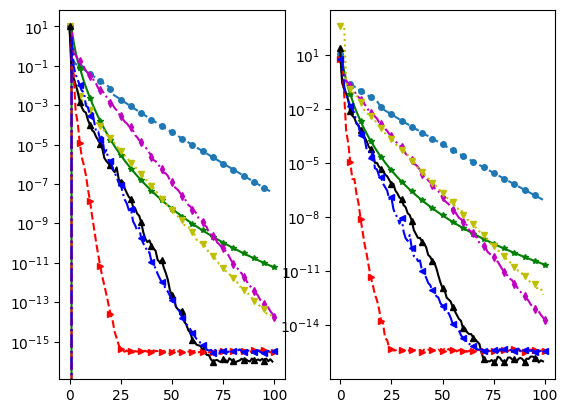

In [48]:
## Number of methods
hist, it_plt, error, op_norm = [], [], [], []
for i in range(len(output_all)):
    hist   = output_all[i].get("epoch_hist")
    it_plt.append( [h.get("epoch") for h in hist] )
    error.append( [h.get("error") for h in hist] )
    op_norm.append( [h.get("op_norm") for h in hist] )

## This is for plottings
alg_name = ['OG', 'AOG', 'SagaRF', 'VrFRBS', 'VrEG', 'AVFR-Svrg', 'AVFR-Saga']
colors   = ['C0', 'g', 'm', 'y', 'k', 'r', 'b', 'C1', 'C2']
line_styles = ['--', '-', '-.', ':', '-', '--', '-.', '-', '--']
my_markers = ['o', '*', 'd', 'v', '^', '>', '<', 's', 'o']


## Now we plot the results.
fig, axs = plt.subplots(1, 2)# , figsize=(10, 8))
for i in range(len(output_all)):
    axs[0].semilogy(it_plt[i], error[i], color=colors[i], linestyle=line_styles[i],\
                    marker = my_markers[i], markersize=4, markevery=5, label=alg_name[i])
    axs[1].semilogy(it_plt[i], op_norm[i], color=colors[i], linestyle=line_styles[i],\
                    marker = my_markers[i], markersize=4, markevery=5, label=alg_name[i])
axs[0].legend()
axs[1].legend()

plt.show()
